In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import numpy as np
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [2]:
# read in csv as dataframe
county_df = pd.read_csv('https://mydataclassdb-bucket.s3.amazonaws.com/covid_and_politics_db.csv')
county_df.head()

,county,state,county_state,lat,long,totalpop,total_votes20,votes20_donald_trump,votes20_joe_biden,percentage20_donald_trump,...,age_55to64,age_65to74,age_75to84,age_84plus,evangelicals,protestant,catholic,orthodox,muslim,other
0,Kay,OK,"Kay, OK",36.817997,-97.144214,45173,17249,12834,4040,0.744,...,5694,4632,2724,1183,0,0,0,0,0,0
1,Abbeville,SC,"Abbeville, SC",34.223334,-82.461707,24788,12433,8215,4101,0.661,...,3584,3150,1602,591,0,0,0,0,0,0
2,Acadia,LA,"Acadia, LA",30.295065,-92.414197,62607,28425,22596,5443,0.795,...,0,0,0,0,0,0,0,0,0,0
3,Accomack,VA,"Accomack, VA",37.767072,-75.632346,32840,16938,9172,7578,0.542,...,5270,4451,2301,886,0,0,0,0,0,0
4,Ada,ID,"Ada, ID",43.452658,-116.241552,435117,259389,130699,120539,0.504,...,56615,42027,18576,7189,0,0,0,0,0,0


In [21]:
# get a list of columns
county_df.columns

Index(['county', 'state', 'county_state', 'lat', 'long', 'totalpop',
       'total_votes20', 'votes20_donald_trump', 'votes20_joe_biden',
       'percentage20_donald_trump', 'percentage20_joe_biden', 'cases',
       'deaths', 'men', 'women', 'hispanic', 'white', 'black', 'native',
       'asian', 'pacific', 'income', 'incomepercap', 'poverty', 'professional',
       'service', 'office', 'construction', 'production', 'drive', 'carpool',
       'transit', 'walk', 'othertransp', 'workathome', 'meancommute',
       'employed', 'privatework', 'publicwork', 'selfemployed', 'familywork',
       'unemployment', 'cases_per_capita_100k', 'deaths_per_capita_100k',
       'pop_per_sq_mile_2010', 'age_oto4', 'age_5to14', 'age_15to24',
       'age_25to34', 'age_35to44', 'age_45to54', 'age_55to64', 'age_65to74',
       'age_75to84', 'age_84plus', 'evangelicals', 'protestant', 'catholic',
       'orthodox', 'muslim', 'other', 'normalized_cases'],
      dtype='object')

In [22]:
X = county_df['percentage20_donald_trump'].values.reshape(-1,1)
X[:5]

array([[0.744],
       [0.661],
       [0.795],
       [0.542],
       [0.504]])

In [23]:
county_df['normalized_cases'] = county_df['cases']/county_df['totalpop']
county_df['normalized_cases']

0       0.020366
1       0.032475
2       0.050825
3       0.037363
4       0.040106
          ...   
3043    0.037071
3044    0.031420
3045    0.050655
3046    0.041854
3047    0.024638
Name: normalized_cases, Length: 3048, dtype: float64

In [24]:
y = county_df['normalized_cases']
y[:5]

0    0.020366
1    0.032475
2    0.050825
3    0.037363
4    0.040106
Name: normalized_cases, dtype: float64

In [25]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:       normalized_cases   R-squared (uncentered):                   0.681
Model:                            OLS   Adj. R-squared (uncentered):              0.681
Method:                 Least Squares   F-statistic:                              6517.
Date:                Fri, 12 Mar 2021   Prob (F-statistic):                        0.00
Time:                        19:03:44   Log-Likelihood:                          7763.5
No. Observations:                3048   AIC:                                 -1.552e+04
Df Residuals:                    3047   BIC:                                 -1.552e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [26]:
print('Parameters: ', results.params)
print('Standard errors: ', results.bse)
print('Predicted values: ', results.predict())

Parameters:  x1    0.041065
dtype: float64
Standard errors:  x1    0.000509
dtype: float64
Predicted values:  [0.03055199 0.02714364 0.03264628 ... 0.03014135 0.03469951 0.03646528]


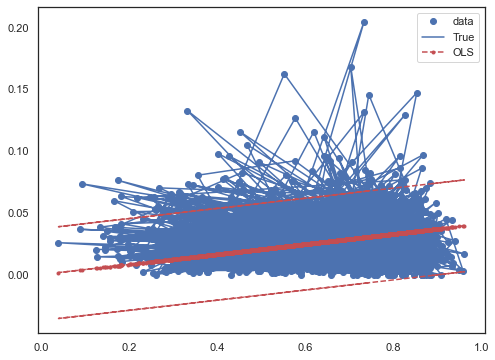

In [27]:
prstd, iv_l, iv_u = wls_prediction_std(results)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(X, y, 'o', label="data")
ax.plot(X, y, 'b-', label="True")
ax.plot(X, results.fittedvalues, 'r--.', label="OLS")
ax.plot(X, iv_u, 'r--')
ax.plot(X, iv_l, 'r--')
ax.legend(loc='best');

In [28]:
X2 = county_df['percentage20_joe_biden'].values.reshape(-1,1)
X2[:5]

array([[0.234],
       [0.33 ],
       [0.191],
       [0.447],
       [0.465]])

In [29]:
y2 = county_df.normalized_cases
y2[:5]

0    0.020366
1    0.032475
2    0.050825
3    0.037363
4    0.040106
Name: normalized_cases, dtype: float64

In [30]:
model2 = sm.OLS(y2, X2)
results2 = model.fit()
print(results2.summary())

                                 OLS Regression Results                                
Dep. Variable:       normalized_cases   R-squared (uncentered):                   0.681
Model:                            OLS   Adj. R-squared (uncentered):              0.681
Method:                 Least Squares   F-statistic:                              6517.
Date:                Fri, 12 Mar 2021   Prob (F-statistic):                        0.00
Time:                        19:03:48   Log-Likelihood:                          7763.5
No. Observations:                3048   AIC:                                 -1.552e+04
Df Residuals:                    3047   BIC:                                 -1.552e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

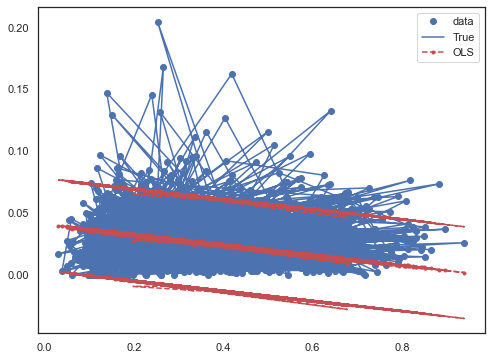

In [46]:
prstd, iv_l, iv_u = wls_prediction_std(results2)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(X2, y2, 'o', label="data")
ax.plot(X2, y2, 'b-', label="True")
ax.plot(X2, results2.fittedvalues, 'r--.', label="OLS")
ax.plot(X2, iv_u, 'r--')
ax.plot(X2, iv_l, 'r--')
ax.legend(loc='best');

In [51]:
county_df['normalized_totalvotes'] = county_df['total_votes20']/county_df['totalpop']
county_df['normalized_totalvotes'].head()

0    0.381843
1    0.501573
2    0.454023
3    0.515773
4    0.596136
Name: normalized_totalvotes, dtype: float64

In [60]:
X3 = county_df['normalized_totalvotes'].values.reshape(-1,1)
X3[:5]

array([[0.38184314],
       [0.50157334],
       [0.45402271],
       [0.51577345],
       [0.59613621]])

In [61]:
y3 = county_df.normalized_cases
y3[:5]

0    0.020366
1    0.032475
2    0.050825
3    0.037363
4    0.040106
Name: normalized_cases, dtype: float64

In [62]:
model3 = sm.OLS(y3, X3)
results3 = model.fit()
print(results3.summary())

                                 OLS Regression Results                                
Dep. Variable:       normalized_cases   R-squared (uncentered):                   0.681
Model:                            OLS   Adj. R-squared (uncentered):              0.681
Method:                 Least Squares   F-statistic:                              6517.
Date:                Fri, 12 Mar 2021   Prob (F-statistic):                        0.00
Time:                        19:31:48   Log-Likelihood:                          7763.5
No. Observations:                3048   AIC:                                 -1.552e+04
Df Residuals:                    3047   BIC:                                 -1.552e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

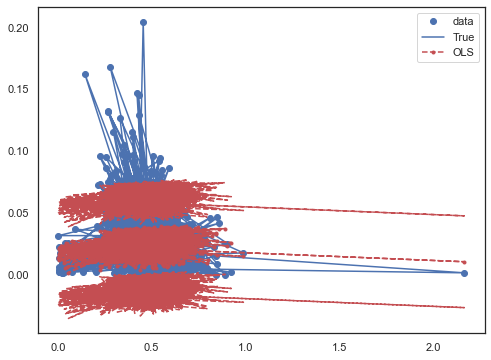

In [63]:
prstd, iv_l, iv_u = wls_prediction_std(results3)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(X3, y3, 'o', label="data")
ax.plot(X3, y3, 'b-', label="True")
ax.plot(X3, results3.fittedvalues, 'r--.', label="OLS")
ax.plot(X3, iv_u, 'r--')
ax.plot(X3, iv_l, 'r--')
ax.legend(loc='best');

In [35]:
X4 = county_df['construction'].values.reshape(-1,1)
X4[:5]

array([[12.8],
       [10.6],
       [15. ],
       [15.1],
       [ 6.9]])

In [52]:
y4 = county_df.normalized_cases
y4[:5]

0    0.020366
1    0.032475
2    0.050825
3    0.037363
4    0.040106
Name: normalized_cases, dtype: float64

In [53]:
model4 = sm.OLS(y4, X4)
results4 = model4.fit()
print(results4.summary())

                                 OLS Regression Results                                
Dep. Variable:       normalized_cases   R-squared (uncentered):                   0.707
Model:                            OLS   Adj. R-squared (uncentered):              0.707
Method:                 Least Squares   F-statistic:                              7339.
Date:                Fri, 12 Mar 2021   Prob (F-statistic):                        0.00
Time:                        19:28:18   Log-Likelihood:                          7889.1
No. Observations:                3048   AIC:                                 -1.578e+04
Df Residuals:                    3047   BIC:                                 -1.577e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

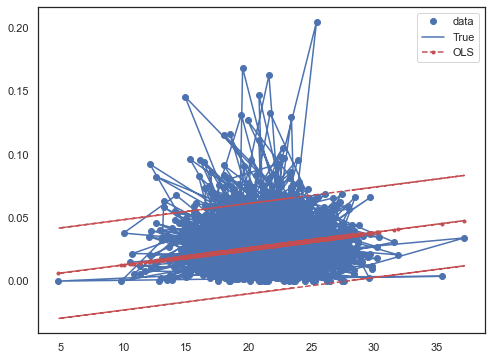

In [64]:
prstd, iv_l, iv_u = wls_prediction_std(results4)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(X4, y4, 'o', label="data")
ax.plot(X4, y4, 'b-', label="True")
ax.plot(X4, results4.fittedvalues, 'r--.', label="OLS")
ax.plot(X4, iv_u, 'r--')
ax.plot(X4, iv_l, 'r--')
ax.legend(loc='best');

In [65]:
X5 = county_df['office'].values.reshape(-1,1)
X5[:5]

array([[23.5],
       [20.8],
       [25.7],
       [18.8],
       [25. ]])

In [66]:
y5 = county_df.normalized_cases
y5[:5]

0    0.020366
1    0.032475
2    0.050825
3    0.037363
4    0.040106
Name: normalized_cases, dtype: float64

In [67]:
model5 = sm.OLS(y5, X5)
results5 = model5.fit()
print(results5.summary())

                                 OLS Regression Results                                
Dep. Variable:       normalized_cases   R-squared (uncentered):                   0.707
Model:                            OLS   Adj. R-squared (uncentered):              0.707
Method:                 Least Squares   F-statistic:                              7339.
Date:                Fri, 12 Mar 2021   Prob (F-statistic):                        0.00
Time:                        19:32:51   Log-Likelihood:                          7889.1
No. Observations:                3048   AIC:                                 -1.578e+04
Df Residuals:                    3047   BIC:                                 -1.577e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

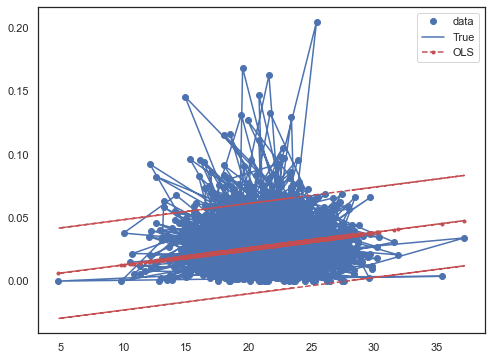

In [68]:
prstd, iv_l, iv_u = wls_prediction_std(results5)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(X5, y5, 'o', label="data")
ax.plot(X5, y5, 'b-', label="True")
ax.plot(X5, results5.fittedvalues, 'r--.', label="OLS")
ax.plot(X5, iv_u, 'r--')
ax.plot(X5, iv_l, 'r--')
ax.legend(loc='best');